## Polynomial curve fitting 

We start with a simple example. Lets take a funcion $sin(2\pi x)$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
example = lambda x : np.sin(2 * np.pi * x)

(-10.0, 110.0)

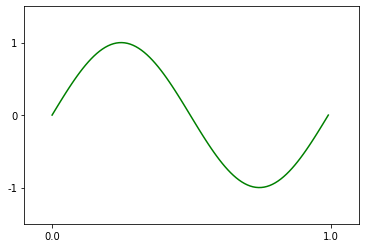

In [3]:
true = [example(x) for x in np.linspace(0, 1, 100)]
plt.plot(true, c='g')
plt.xticks(np.linspace(0, 100, 2), np.linspace(0, 1, 2))
plt.yticks(np.linspace(-1, 1, 3), np.linspace(-1, 1, 3).astype(int))
plt.ylim(-1.5, 1.5)
plt.xlim(-10, 110)

Sadly in practice you will never know this true underlying function. To mimic this we add a gaussian error to our data sample 

In [316]:
def create_training_data(input_size, noise=0.3, mean=0.0):
    input_ = np.linspace(0.01,1, input_size)
    true_data = np.array([example(x) for x in input_])
    gaussian_error = np.random.normal(0, 0.3, input_size)
    
    return true_data + gaussian_error, input_

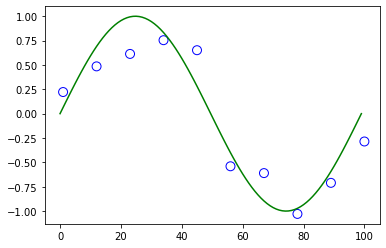

In [319]:
training_data, input_ = create_training_data(10)

plt.plot(true, c='g')
plt.scatter(input_ * 100, training_data, s=80, facecolor='none', edgecolors='blue')

For now we are going to approximate this sinus wave by fitting a $M$th polynomial function

$$
    y(x, w) = \sum_{j=0}^{M}w_jx^j
$$

A standard method for calculating the optimal $w$ is bone by minimizing the error function named sum of squares

$$
    E(w) = \frac{1}{2}\sum_{i=1}^N(y(x_n,w) - t_n)^2
$$

To solve this we can find the derivative of $w_i$ (note the partial derivative) and set to zero. First we will do this for $M=0$ (or only the intercept)

$$
    \frac{dE}{dw_0} = \sum_{i=1}^{N}(\sum_{j=0}^{M}w_jx^j - t_n)x^0 \\
    \sum_{j=0}^{M}w_jx^j x^0 = t_nx^0
$$

Since $M=0$ and anything to the power 0 is 1 we can greatly simplify this equation

$$
    w_0 = \frac{\sum_{i=1}^{N} t_n}{N}
$$

Meaning that when you pick a zero order polynomial you just end up with the mean

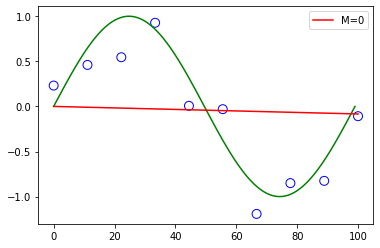

In [227]:
plt.plot(true, c='g')
input_ = np.linspace(0,100, input_size)
plt.scatter(input_, training_data, s=80, facecolor='none', edgecolors='blue')
plt.plot([0,100], [0, training_data.sum() / training_data.size], c='r', label='M=0')
plt.legend()
plt.show()

For the generalization it is easier to leave the coupled linear equations and use a matrix notation and solve using the pseudo inverse (described in chapter 3). To calculate this you first transform the values on the x axis into a matrix having all the values to the Nth polynomial

In [516]:
def get_polynomials(data_size, M, input_):
    X = np.zeros((data_size, M + 1))

    for i in range(M + 1):
        X[:,i] = np.power(input_, i).reshape(-1,)
        
    return X

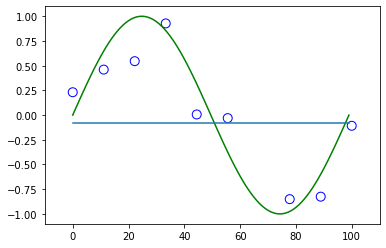

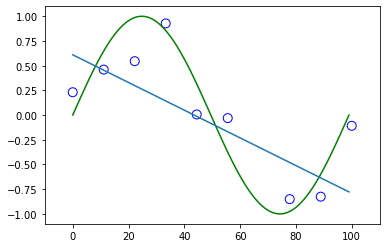

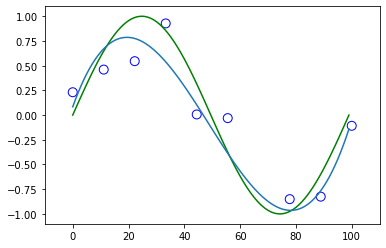

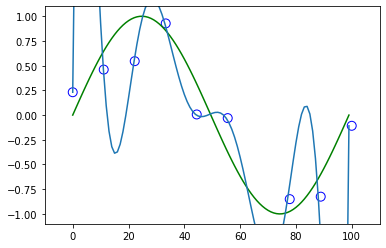

In [229]:
for m in [0, 1, 3, 9]:
    X = get_polynomials(training_data.size, m)
    w_star = np.linalg.inv(X.T @ X) @ X.T @ training_data
    
    X = get_polynomials(100, m)
    plt.plot(true, c='g')
    plt.scatter(np.linspace(0,100, training_data.size), training_data, s=80, facecolor='none', edgecolors='blue')
    plt.plot((X @ w_star.reshape(-1,1)).flatten())
    plt.ylim(-1.1, 1.1)
    plt.xlim(-10, 110)
    plt.show()

What this shows is that with a higher order polynomial overfitting occurs. 3 seems about right. The sum of squares approach is dependent on the number of data points as show below

In [244]:
def print_polynomial(axes, training_data, w_star, X):
    axes.plot(true, c='g')
    axes.scatter(np.linspace(0,100, training_data.size), training_data, s=80, facecolor='none', edgecolors='blue')
    axes.plot((X @ w_star.reshape(-1,1)).flatten())    
    axes.set_ylim(-1.1, 1.1)
    axes.set_xlim(-10, 110)
    
    return axes

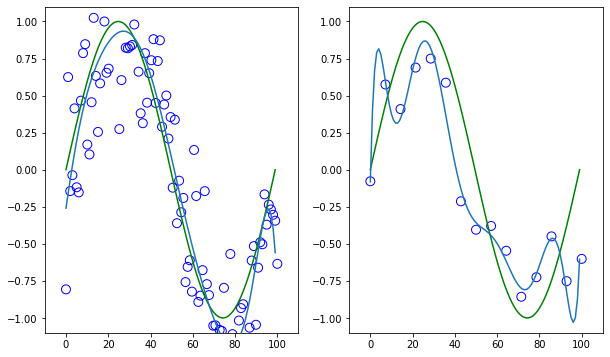

In [264]:
training_data = create_training_data(100)
X = get_polynomials(training_data.size, 9)

w_star = np.linalg.inv(X.T @ X) @ X.T @ training_data
X = get_polynomials(100, m)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
axes[0] = print_polynomial(axes[0], training_data, w_star, X)

training_data = create_training_data(15)
X = get_polynomials(training_data.size, 9)

w_star = np.linalg.inv(X.T @ X) @ X.T @ training_data
X = get_polynomials(100, m)

axes[1] = print_polynomial(axes[1], training_data, w_star, X)

As you can see the more data that you have the better a higher order polynomial will fit. One other way to assess the fit of your data is by using a bayesian approach. Here you assume that the error around a predicted value $t$ and its uncertainty is normally distributed

$$
    p(t|x, w, \beta) = \mathcal{N}(t|y(x, w), \beta^{-1})
$$

To determine the values for $w$ and $\beta^{-1}$ we use a maximum likelihood estimation. It is convevient to use the log likelihood in order to prevent underflow.

$$
    -\frac{\beta}{2} \sum_{n=1}^N (y(x_n, w) -t_n)^2 + \frac{N}{2} ln \beta - \frac{N}{2} ln(2\pi)
$$

Now we want to calculate $w_{MLE}$. For this we can notice that w only depends on the left most part of the equation so we remove the rest and set the derivative of w to zero of the last part. As you can see this is the same as finding the w in the regression case, i.e.e you can use the pseudo inverse solution. Having found W we can look for $\beta$ by setting the derivative of $\beta$ to zero and using our maximum W

$$
    \frac{1}{2}(w^T x - t)^2 + \frac{N}{2 \beta} \\
    \frac{N}{2 \beta} = \frac{1}{2}(w^Tx - t)^2 \\
    \frac{1}{\beta} = \frac{1}{N}(w^Tx - t)^2
$$

No that we have $\beta$ and w we can fit a predictive distribution 

$$
    p(t|x, w_{ML}, \beta_{ML}) = \mathcal{N}(t|y(x, w_{ML}), \beta^{-1}_{ML})
$$

To get a full Bayesian approach we add a prior probability (zero mean Gaussian with hyperparemeter precision $\alpha$) to get

$$
    p(w|x, t, \alpha, \beta) = p(t|x,w,\beta)p(w|a)
$$

Notice that we can now calculate the optimal w given all the data (so the target t as well). So instead of calculating the probability of the target using MLE we can use Bayesian to calculate W directly using the posterior probability. For this reason this method is called the maximum posterior (or MAP)

$$
    p(w|x,t,a,b) \propto p(t|x,w,b)p(w|a)
$$

Taking the log of the likelihood specified above and the zero mean conditional on a you can see that maximizing the posterior probability is the same as minimizzing the regularized sum-of-squares in the MLE example. 

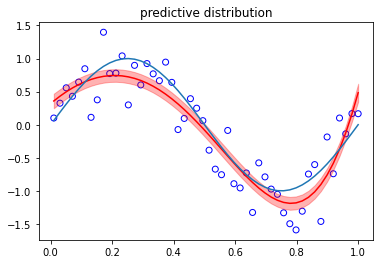

In [630]:
b = 1/0.3**2 # Precision is the inverse of the variance
a = 5 * 10e-3 # This is how much variance you give in the prior gaussian distribution for w
num_examples = 50
t, input_ = create_training_data(num_examples)
t = t.reshape(-1, 1)
phi = get_polynomials(num_examples, 9, input_=input_).T

S = np.linalg.inv((a * np.identity(10)) + b * (phi @ phi.T))

variances = np.diag((1/b) + (phi.T @ S) @ phi).reshape(-1, 1)
means = b * phi.T @ S @ (phi @ t)

plt.scatter(input_, t, facecolor='none', edgecolors='blue')
plt.plot(input_, means, c='r')
plt.plot(input_, [example(x) for x in input_])
top = means + stats.norm(means, variances).std()
bottom = means - stats.norm(means, variances).std()
plt.fill_between(input_, top.flatten(), bottom.flatten(), color='r', alpha=0.30)
plt.title('predictive distribution')
plt.show()

The higher the precision is (lower variance) or the more data there is the smaller the red band becoems and thus you have a more certain prediction. The deridvation of these bands is discussed in chapter 3

## Information Theory

For now I will only focus on entropy since it is the most important aspect of information theory in ML. Here we will take a look to derive entropy using buckets. Lets say you have $N$ elements into buckets such that in bucket $i$ there are $n_i$ elements in that bucket. We are only interested in the possible permutations over all the buckets (macrostate) and not inside a bucket (microstate). For this reasaon the number of way we can allocate N items in the buckets is shown as 

$$
    W = \frac{N!}{\Pi_i n_i!}
$$

En tropy is defined as $-\frac{1}{N}ln W$. When we increase the number of items to infinity entropy will approach

$$
    H = -lim_{N\to\infty} \sum_i(\frac{n_i}{N}) ln (\frac{n_i}{N})
$$

where $p(x_i) = \frac{n_i}{N}$ such that 

$$
    H = - \sum_ip(x_i) \; ln \; p(x_i)
$$

Here we assume a distribution that has 30 bins

In [126]:
from scipy import stats

In [169]:
def calculate_entropy(discritized):
    entropy = 0
    for bucket in discritized:
        if bucket == 0: # An empty bucket is not defined
            continue 

        entropy -= (bucket / discritized.sum()) * np.log(bucket / discritized.sum())
        
    return entropy

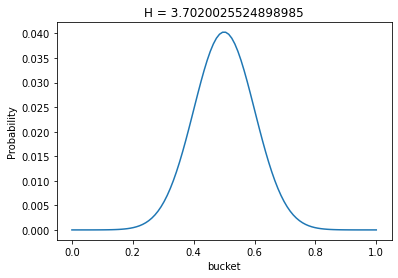

In [217]:
norm1 = stats.norm(0.5, 0.1)
plt.plot(np.linspace(0, 1, 100), norm1.pdf(np.linspace(0, 1, 100)) / norm1.pdf(np.linspace(0, 1, 100)).sum())
discritized = (norm1.pdf(np.linspace(0, 1, 100)) * 100).astype(int)
plt.title(f'H = {calculate_entropy(discritized)}')
plt.xlabel('bucket')
plt.ylabel('Probability')
plt.show()

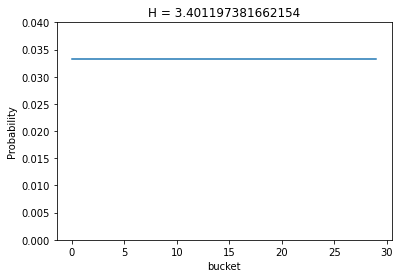

In [221]:
plt.plot((stats.uniform(loc=0, scale=1).pdf(np.linspace(0, 1, 30))) / 30)
discritized = ((stats.uniform(loc=0, scale=1).pdf(np.linspace(0, 1, 30))) / 30 * 100).astype(int)
plt.title(f'H = {calculate_entropy(discritized)}')
plt.xlabel('bucket')
plt.ylabel('Probability')
plt.ylim(0, 0.04)
plt.show()